# Example 0
## Anomaly detection in artificial data with linear neuron
In this example we demonstrate the capabilities of Learning Entropy on anomaly detection for artificial signal monitored with linear neuron. 

In this example we first generate 3 sinus signals with 3 different frequencies. To the generated signal we then plant an anomaly (frequency change, amplitude change, phase shift)

In [1]:
# Import required libs
import sys
import time

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("..")

# Pythonic AISLE
from src.aisle import aisle as py_aisle
from src.aisle import aisle_window as py_aisle_window

# JAX accelerated AISLE
from src.aisle_jax import aisle as jax_aisle
from src.aisle_jax import aisle_window as jax_aisle_window

%matplotlib widget

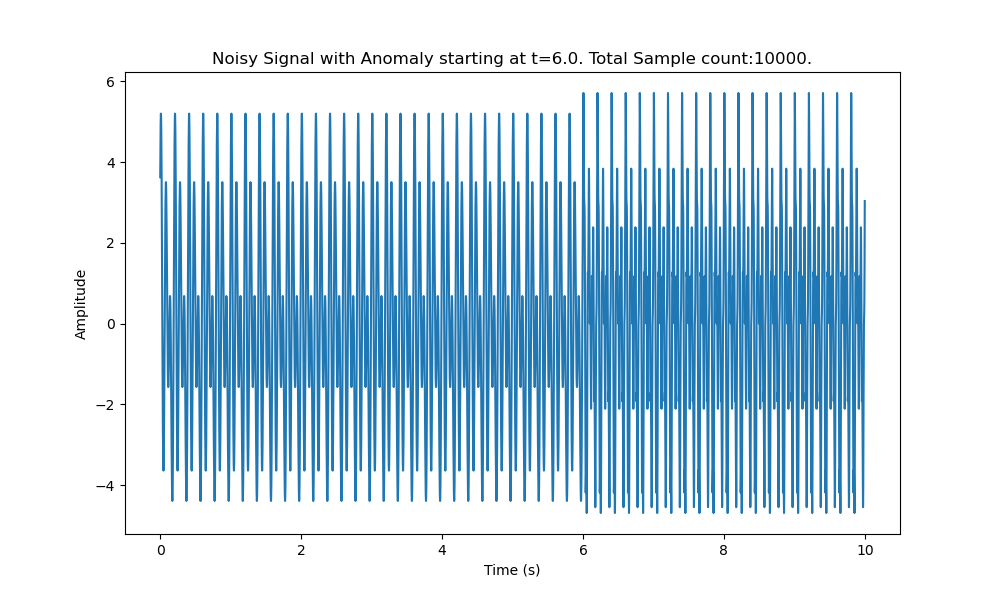

In [2]:
# Constants
frequencies = [5, 10, 15]  # Frequencies in Hz for each signal
amplitudes = [1, 2, 3]  # Amplitudes for each signal
phases = [0, 1.275, 6.89]  # Phases in radians for each signal
anomaly_start = 6000  # Anomaly start position
noise_level = 0.0  # Noise level

# Anomaly parameters
anomaly_type = {"frequency":50, "amplitude":0.5}  # Options: 'amplitude', 'frequency', 'phase'
corrupted_signal_index = 0  # Index for which signal to corrupt: 0 for signal1, 1 for signal2, 2 for signal3

# Time domain
t = np.arange(0, 10, 0.001)

# Generate signals
signals = [amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t + phases[i]) for i in range(3)]

# Introduce anomaly in the chosen signal from Nth position
anomaly_type_keys = list(anomaly_type.keys())
if "amplitude" in anomaly_type_keys:
    signals[corrupted_signal_index][anomaly_start:] = anomaly_type["amplitude"] * \
        np.sin(2 * np.pi * frequencies[corrupted_signal_index] * t[anomaly_start:] + phases[corrupted_signal_index])
if "frequency" in anomaly_type_keys:
    signals[corrupted_signal_index][anomaly_start:] = amplitudes[corrupted_signal_index] * \
        np.sin(2 * np.pi * anomaly_type["frequency"] * t[anomaly_start:] + phases[corrupted_signal_index])
if "phase" in anomaly_type_keys:
    signals[corrupted_signal_index][anomaly_start:] = amplitudes[corrupted_signal_index] * \
        np.sin(2 * np.pi * frequencies[corrupted_signal_index] * t[anomaly_start:] + anomaly_type["phase"])

# Combine signals
combined_signal = np.sum(signals, axis=0)

# Generate and add noise
noise = np.random.normal(0, noise_level, combined_signal.shape)
data = combined_signal + noise

# Plot the combined signal with noise
plt.figure(figsize=(10, 6))
plt.plot(t, data, label="Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Noisy Signal with Anomaly starting at t={t[anomaly_start]}. Total Sample count:{len(t)}.")
plt.show()

In [3]:
# Prepare higher order neural unit and training data
N = data.shape[0]
nu = 20  # This can be set dynamically to decide the number of historical values
prediction_horizon = 1

# Prepare higher order neural unit and training data
X = np.ones((N, 1 + nu))  # Holder for prepared features and bias, +1 for the bias term
y = np.zeros((N,))

# Generate X, y dynamically based on 'nu'
for k in range(nu, N - prediction_horizon):
    X[k, 1:] = data[k - nu:k][::-1]  # Assign historical data in reverse order
    y[k] = data[k + prediction_horizon]

# Remove padding used for historical data and prediction horizon
X = X[nu:-prediction_horizon, :]
y = y[nu:-prediction_horizon]


In [4]:
mu = 0.1  # Learning rate
epochs = 2  # Number of epochs for training

# Initialize parameters
N = X.shape[0]  # Number of samples
print(f"The total amount of samples: {N}.")
nx = X.shape[1]  # Input features count
nw = nx  # For LNU, the number of weights is the same as the number of input features
w = np.random.randn(nw) / nw  # Initialize weights

# Holders for adaptation values
e = np.zeros(N)
yn = np.zeros(N)
Wall = np.zeros((N, nw))

# Training Linear Neural Unit
for epoch in range(epochs):
    for k in range(N):
        x = X[k, :]
        yn[k] = np.dot(w, x)  # Calculate the predicted value
        e[k] = y[k] - yn[k]  # Calculate the error
        dyndw = x  # Gradient for LNU

        # Update weights
        # Uncomment the desired weight update rule

        # Pure Gradient Descent (GD)
        # dw = mu * e[k] * dyndw

        # GD with normalization
        dw = mu / (sum(x * x)) * e[k] * dyndw  # x0=1 => division by zero is avoided

        # GD with normalization and momentum
        # dw = 0.2 * mu / (sum(x * x)) * e[k] * dyndw + 0.8 * dw

        w = w + dw  # Update weights
        Wall[k, :] = w  # Store weights for analysis

    # Optional: Print epoch error or other metrics
    epoch_error = np.mean(e ** 2)
    print(f"Epoch {epoch+1} Mean Squared Error: {epoch_error}")


The total amount of samples: 9979.
Epoch 1 Mean Squared Error: 0.06317776755955741
Epoch 2 Mean Squared Error: 0.017263624221668303


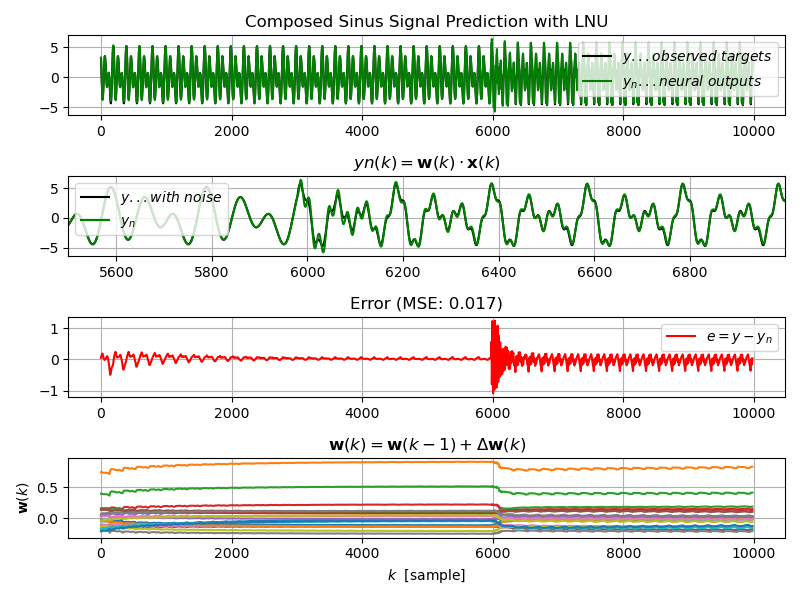

In [5]:
# Calculate Mean Squared Error and round it to 3 digits
error = round(epoch_error, 3)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=.5)

# Plot observed targets and neural outputs
ax1 = plt.subplot(411)
plt.title("Composed Sinus Signal Prediction with LNU")
plt.plot(y, "k", label=r"$y ... observed \ targets$")
plt.plot(yn, "g", label=r"$y_n ... neural \ outputs$")
plt.legend()
plt.grid()

# Plot last 100 samples of noisy and neural outputs
ax2 = plt.subplot(412)
plt.title(r"$yn(k)=\mathbf{w}(k) \cdot \mathbf{x}(k)$")
sample_range = np.arange(anomaly_start-500, anomaly_start+1000)  # Correct X axis for the last 100 samples
plt.plot(sample_range, y[anomaly_start-500:anomaly_start+1000], "k", label=r"$y...with \ noise$")
plt.plot(sample_range, yn[anomaly_start-500:anomaly_start+1000], "g", label=r"$y_n$")
plt.xlim(sample_range[0], sample_range[-1])  # Set x-axis limits
plt.grid()
plt.legend()


# Plot error between observed targets and neural outputs
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(e, "r", label=r"$e=y-y_n$")
plt.title(f"Error (MSE: {error})")  # Include MSE in the title
plt.legend()
plt.grid()

# Plot weights adaptation
ax4 = plt.subplot(414, sharex=ax1)
plt.plot(Wall), plt.ylabel(r"$\mathbf{w}(k)$")
plt.title(r"$\mathbf{w}(k)=\mathbf{w}(k-1)+\Delta \mathbf{w}(k)$")
plt.grid()
plt.xlabel(r"$k$  [sample]")

plt.tight_layout()
plt.show()

## AISLE
In this part we will demonstrate usage of AISLE on our generated data.

In [11]:
# Single AISLE value retrieval
oles = (1, 2)
alphas = (10, 15)

# Python single Learning Entropy evaluation
py_aisle_time = time.time()
py_aisle_value = py_aisle(Wall, alphas=alphas, oles=oles)
py_aisle_time = time.time() - py_aisle_time

# JAX accelerated single Learning Entropy evaluation
jax_aisle_time = time.time()
jax_aisle_value = jax_aisle(Wall, alphas=alphas, oles=oles)
jax_aisle_time = time.time() - jax_aisle_time

msg = (f"Single Learning Entropy evaluation with pythonic approach took: {py_aisle_time:.2f} seconds.\n",
       f"Single Learning Entropy evaluation with JAX aproach took: {jax_aisle_time:.2f} seconds.\n\n",
       "Single evaluation with JAX is in general slower, as on its first run it has to compile parts of",
       "the code.\nRepeated usage is recommended. If reporting evaluation time is 0.00, cache has been used."
)
msg = "".join(text for text in msg)
print(msg)

Single Learning Entropy evaluation with pythonic approach took: 0.01 seconds.
Single Learning Entropy evaluation with JAX aproach took: 0.00 seconds.

Single evaluation with JAX is in general slower, as on its first run it has to compile parts ofthe code.
Repeated usage is recommended. If reporting evaluation time is 0.00, cache has been used.


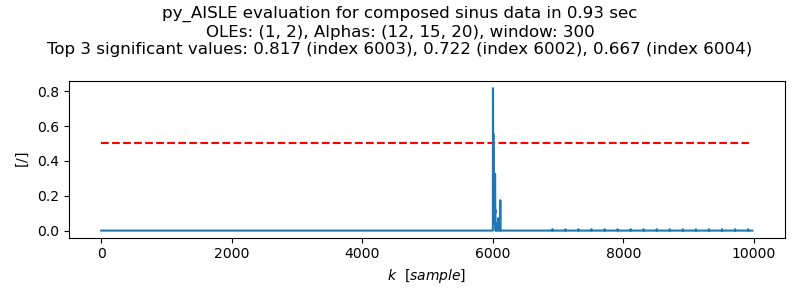

In [7]:
# Aisle setup
oles = (1, 2)  # Derivations of weights
alphas = (12, 15, 20)  # Sensitivity of evaluation
window = 300  # Window evaluated for each AISLE values
threshold = 0.5

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(X.shape[0])
py_aisle_time = time.time()
aisle_values[nx:] = np.sum(py_aisle_window(window, Wall, alphas, oles)[:-nx], axis=1) / len(oles)  # Pythonic
py_aisle_time = time.time() - py_aisle_time

# Identify indices where aisle_values are above given threshold
indices = np.where(aisle_values > threshold)[0]
indices_values = aisle_values[indices]

# Sort these values and select top 3 significant values and their indices
sorted_indices = np.argsort(indices_values)[-3:][::-1]  # Indices of top 3 values in descending order
top_3_indices = indices[sorted_indices]
top_3_values = indices_values[sorted_indices]

# 3. Construct the plot title with the top three significant values
top_values_str = ", ".join([f"{aisle_values[idx]:.3f} (index {idx})" for idx in top_3_indices])
plot_title = (
    f"py_AISLE evaluation for composed sinus data in {py_aisle_time:.2f} sec\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}\n",
    f"Top 3 significant values: {top_values_str}",
)
plot_title = "".join(text for text in plot_title)
# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.hlines([0.5], 0, aisle_values.shape[0], colors="red", linestyles="dashed")
plt.plot(aisle_values, label="AISLE")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$k~~[sample]$")
plt.tight_layout()
plt.show()

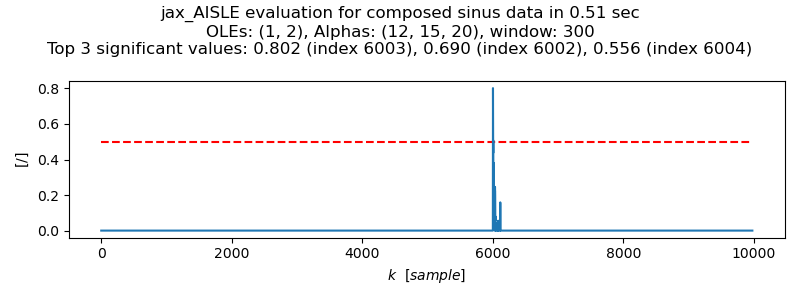

In [8]:
# Aisle setup
oles = (1, 2)  # Derivations of weights
alphas = (12, 15, 20)  # Sensitivity of evaluation
window = 300  # Window evaluated for each AISLE values
threshold = 0.5

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(X.shape[0])
jax_aisle_time = time.time()
aisle_values[nx:] = np.sum(jax_aisle_window(window, Wall, alphas, oles)[:-nx], axis=1) / len(oles)  # Pythonic
jax_aisle_time = time.time() - jax_aisle_time

# Identify indices where aisle_values are above given threshold
indices = np.where(aisle_values > threshold)[0]
indices_values = aisle_values[indices]

# Sort these values and select top 3 significant values and their indices
sorted_indices = np.argsort(indices_values)[-3:][::-1]  # Indices of top 3 values in descending order
top_3_indices = indices[sorted_indices]
top_3_values = indices_values[sorted_indices]

# 3. Construct the plot title with the top three significant values
top_values_str = ", ".join([f"{aisle_values[idx]:.3f} (index {idx})" for idx in top_3_indices])
plot_title = (
    f"jax_AISLE evaluation for composed sinus data in {jax_aisle_time:.2f} sec\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}\n",
    f"Top 3 significant values: {top_values_str}",
)
plot_title = "".join(text for text in plot_title)
# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.hlines([0.5], 0, aisle_values.shape[0], colors="red", linestyles="dashed")
plt.plot(aisle_values, label="AISLE")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$k~~[sample]$")
plt.tight_layout()
plt.show()

In [10]:
meanabsdw = np.mean(abs(Wall[0 : Wall.shape[0] - 1, :]), 0)

In [12]:
meanabsdw*12

array([0.20470843, 6.0195743 , 4.63285099, 2.94703906, 2.79554177,
       1.09277785, 1.15235642, 0.18090597, 0.55614775, 0.93884718,
       0.96591977, 1.90452277, 1.71274562, 1.60114728, 2.00051535,
       1.17920877, 0.37177724, 0.16899574, 0.45199647, 2.11421612,
       2.39029531])

In [20]:
n_alpha = 0
n_alpha += np.sum(np.abs(Wall[-1, :]) > 1 * meanabsdw)
n_alpha

8

In [21]:
float(n_alpha) / (nw * 1)

0.38095238095238093